In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns


from scipy import stats
from scipy.stats import norm, skew

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
arabica_data = pd.read_csv('./coffee-quality-database-master/data/arabica_data_cleaned.csv')
arabica_data.head()

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,2,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,3,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,4,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,5,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


# Washed / Wet processing method
- Variety null -> other
- Coffee_Name 생성
- arabica_data에서 맛 순서에 따라 ordering 진행 -> 추후 get_dummies 필요

In [3]:
arabica_data_wet = arabica_data.loc[arabica_data['Processing.Method'] == 'Washed / Wet']

# variety가 없는 경우 Other로 묶기
arabica_data_wet['Variety'] = arabica_data_wet['Variety'].fillna('Other')

arabica_data_wet['Coffee_Name'] = [arabica_data_wet['Country.of.Origin'].iloc[i] + '_' + arabica_data_wet['Variety'].iloc[i]
                                     if arabica_data_wet['Variety'].iloc[i] != 'Other'
                                     else arabica_data_wet['Country.of.Origin'].iloc[i]
                                     for i in range(len(arabica_data_wet))]

In [4]:
# Ordering
tastes = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance']
uniformity_sweetness = ['Uniformity', 'Sweetness']


for i in range(len(tastes)):
    arabica_data_wet['{}_Rating'.format(tastes[i])] = 0

for i in range(len(arabica_data_wet)):
    ratings = arabica_data_wet[tastes].iloc[i].sort_values(ascending = False).index
    for rating in range(len(ratings)):
        arabica_data_wet['{}_Rating'.format(ratings[rating])].iloc[i] = rating + 1

In [5]:
### Ordering(순서를 매겨, 6 * 5 * 4 * 3 * 2 * 1의 컬럼개수만큼 만듦, 일단 데이터의 개수가 적어 해당 features는 만들지 않음.)

"""arabica_data_wet['Ordering'] = 0
Ordering = set()

features = tastes + uniformity_sweetnees + ['Ordering']
for column in arabica_data_wet.columns:
    if column in features:
        coffee[column] = arabica_data_wet[column]
"""

"""
# categorical feature : 더미변수후 cluster_data와 합침
Order_dummies =  pd.concat((coffee['Coffee_Name'], pd.get_dummies(coffee['Ordering'])), axis = 1).groupby('Coffee_Name').max().reset_index()
cluster_data = pd.concat((cluster_data, Order_dummies.drop(['Coffee_Name'], axis = 1)), axis = 1)
cluster_data.shape
"""

"\n# categorical feature : 더미변수후 cluster_data와 합침\nOrder_dummies =  pd.concat((coffee['Coffee_Name'], pd.get_dummies(coffee['Ordering'])), axis = 1).groupby('Coffee_Name').max().reset_index()\ncluster_data = pd.concat((cluster_data, Order_dummies.drop(['Coffee_Name'], axis = 1)), axis = 1)\ncluster_data.shape\n"

In [6]:
# numerical features : 커피 종류에 따른 mean value 추가
cluster_data = pd.DataFrame({'Coffee_Name' : arabica_data_wet.groupby('Coffee_Name')['Aroma'].mean().index})
ratings = ['Aroma_Rating', 'Flavor_Rating', 'Aftertaste_Rating', 'Acidity_Rating', 'Body_Rating', 'Balance_Rating']
features = tastes + uniformity_sweetness + ratings
for column in features:
    cluster_data[column] = arabica_data_wet.groupby('Coffee_Name')[column].mean().values
    

0.9942366680289851


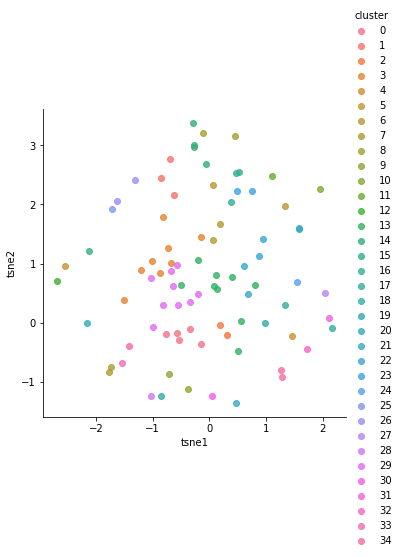

In [7]:
# TSNE에는 정규화를 거치지 않은 X
model = TSNE(n_components = 2, random_state = 0, perplexity = 50)
tsne = model.fit_transform(cluster_data.drop(['Coffee_Name'], axis = 1).values)

# PCA에는 정규화된 X
std = StandardScaler()
s = std.fit_transform(cluster_data.drop(['Coffee_Name'], axis = 1))

pca = PCA(n_components = 7)
pca.fit(cluster_data.drop(['Coffee_Name'], axis = 1))
pc = pca.transform(cluster_data.drop(['Coffee_Name'], axis = 1))
kmeans = KMeans(n_clusters = 35)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1' : tsne[:,0], 'tsne2' : tsne[:, 1], 'cluster' : kmeans.labels_})
sns.lmplot(data = fr, x = 'tsne1', y = 'tsne2', hue = 'cluster', fit_reg = False)
print(np.sum(pca.explained_variance_ratio_))

cluster_data['Cluster'] = kmeans.labels_

# 컬럼별 산점도 확인

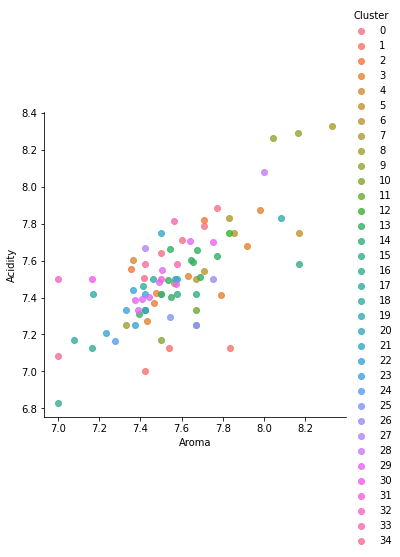

In [8]:
def scatter_plot(data, x, y, hue = 'Cluster'):
    sns.lmplot(data = data, x = x, y = y, hue = hue, fit_reg = False)
    plt.show()
    
scatter_plot(cluster_data, 'Aroma', 'Acidity')

## 클러스터별 각 input variables와의 상관관계 확인

<AxesSubplot:>

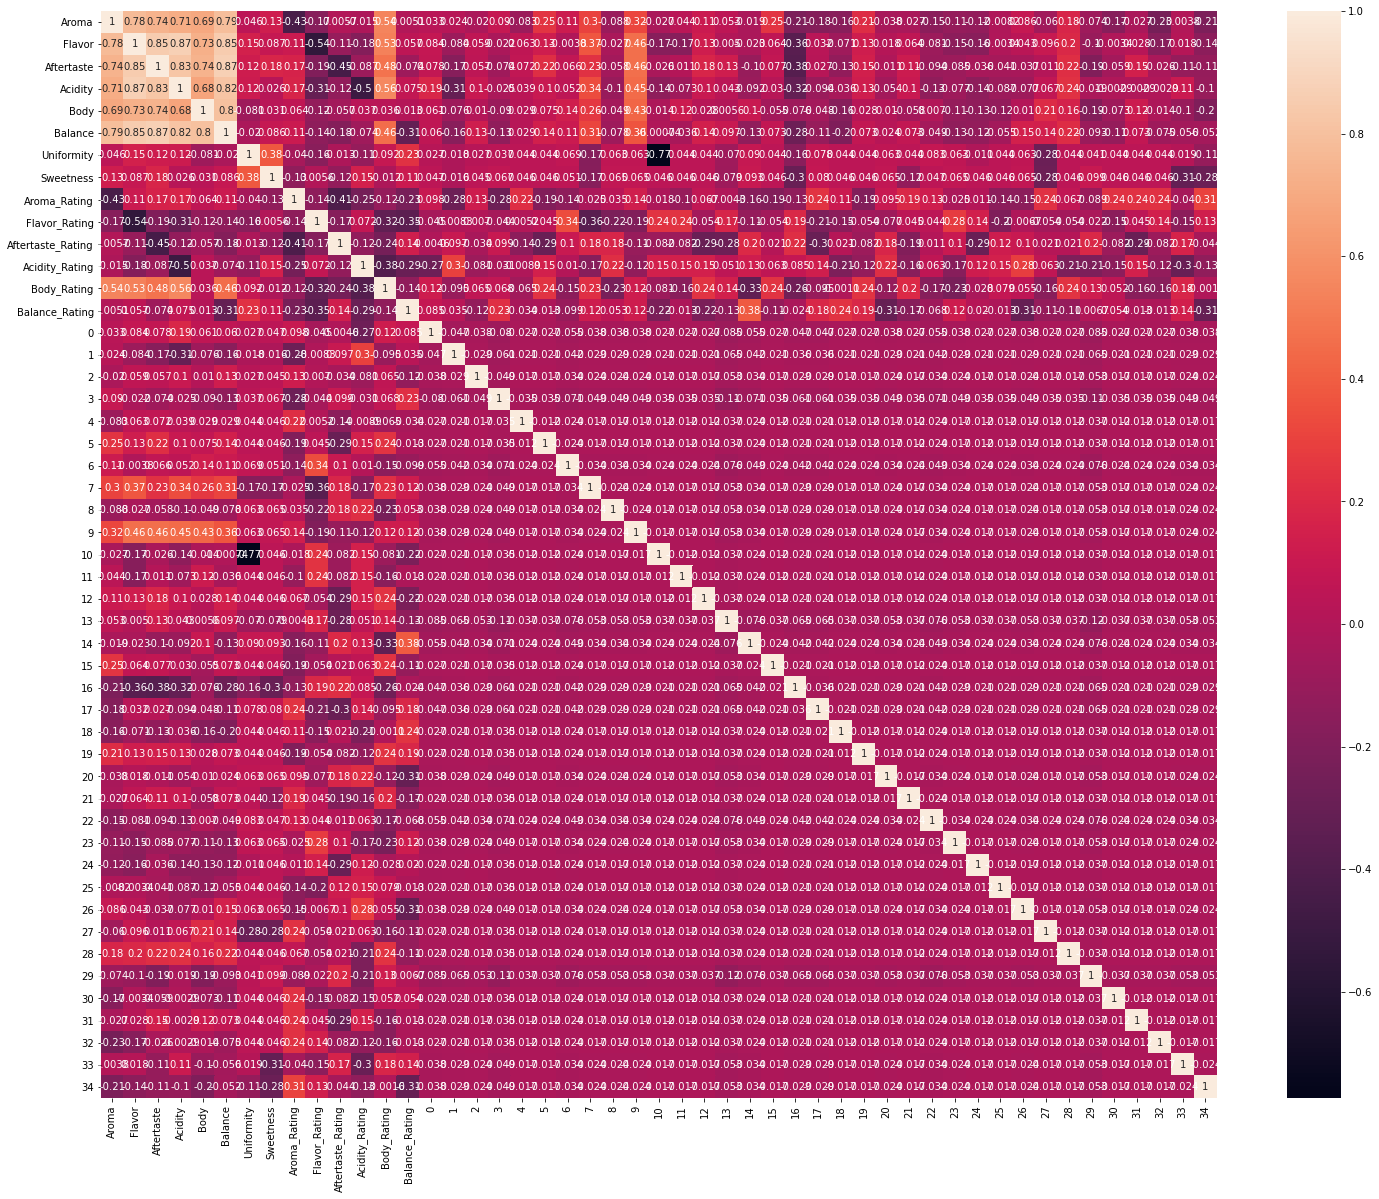

In [9]:
result = pd.concat((cluster_data, pd.get_dummies(cluster_data['Cluster'])), axis = 1)
result.drop(['Cluster'],  axis = 1, inplace = True)

fig, ax = plt.subplots(figsize = (25, 20))

sns.heatmap(result.corr(), annot = True)

In [10]:
arabica_data_wet.Coffee_Name

0               Ethiopia
1               Ethiopia
4               Ethiopia
6                   Peru
11         United States
              ...       
1303     Honduras_Catuai
1304     Honduras_Catuai
1305     Honduras_Catuai
1306      Mexico_Bourbon
1309    Guatemala_Catuai
Name: Coffee_Name, Length: 812, dtype: object

In [11]:
# 블랜딩하는 경우 cluster 예측
# Country : [나라1, 나라2 ...]
# Rate : [0.4, 0.2, ...] / X1 + X2 + ... + Xn = 1
def blending_clustering(Country, Rate, Variety = None):
    blend = 0
    for i in range(len(Country)):
        if Variety == None:
            blend += arabica_data_wet.loc[arabica_data_wet['Country.of.Origin'] == Country[i]][features].mean().apply(lambda x: x * Rate[i])
        else:
            if Variety[i] == None:
                blend += arabica_data_wet.loc[arabica_data_wet['Country.of.Origin'] == Country[i]][features].mean().apply(lambda x: x * Rate[i])
            else:
                blend += arabica_data_wet.loc[arabica_data_wet['Coffee_Name'] == "{}_{}".format(Country[i], Variety[i])][features].mean().apply(lambda x: x * Rate[i])
    blend = pd.DataFrame([blend])
    
    
    # Modeling : DecistionTreeClassifier()
    
    model = DecisionTreeClassifier()
    model.fit(cluster_data.drop(['Cluster', 'Coffee_Name'], axis = 1), kmeans.labels_)
    print(blend)
    model.predict(blend)
    
    print("\n cluster는 '{}'입니다. \n".format(int(model.predict(blend))))
    print("\n 같은 cluster 안에 '{}'이 있습니다.".format(list(cluster_data['Coffee_Name'].loc[cluster_data['Cluster'] == model.predict(blend)[0]])))
    
    return 

# 나라 이름 확인하는 함수
def check_Country():
    return set(arabica_data_wet['Country.of.Origin'])

# 나라에 따른 variety 확인하는 함수
def check_Variety(Country):
    return set(arabica_data_wet['Variety'].loc[arabica_data_wet['Country.of.Origin'] == Country].values)



In [12]:
check_Variety('Brazil')

{'Bourbon', 'Catuai', 'Mundo Novo', 'Other', 'Yellow Bourbon'}

In [13]:
Country = ['Costa Rica', 'Ethiopia', 'Colombia', 'Brazil']
Rate = [.25, .25, .25, .25]
Variety = [None, 'Ethiopian Yirgacheffe', None, None]
blending_clustering(Country, Rate, Variety)

      Aroma    Flavor  Aftertaste   Acidity      Body  Balance  Uniformity  \
0  7.712241  7.600393    7.514974  7.587193  7.545045  7.57988    9.944112   

   Sweetness  Aroma_Rating  Flavor_Rating  Aftertaste_Rating  Acidity_Rating  \
0   9.971308       2.54511       3.505487           4.457163        3.090427   

   Body_Rating  Balance_Rating  
0     3.806198        3.595615  

 cluster는 '3'입니다. 


 같은 cluster 안에 '['Honduras_Catuai', 'Indonesia', 'Indonesia_Java', 'Mexico_Bourbon', 'Mexico_Caturra', 'Mexico_Pacamara', 'Uganda', 'Uganda_SL14']'이 있습니다.


브라질 버번, 엘살바도르버번, 호두라스, 호두라스카투라, 케냐aa, 하와이안코냐